#Initialization

In [0]:
# Loading
import torch
from torchvision import datasets, transforms, utils

# ---- Visualizing
import matplotlib.pyplot as plt
import numpy as np

# Creating a CNN
import torch.nn as nn
import torch.nn.functional as F

# Optimizer
import torch.optim as optim
import time
import random
import torch.utils

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pickle
from torch.utils.data.sampler import (SubsetRandomSampler,
                                      RandomSampler)
from torchvision import datasets, transforms

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('%d gpu(s) available' % torch.cuda.device_count())
print('Using', device)

1 gpu(s) available
Using cuda


In [0]:
# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)

cuda


#Loading Data

In [0]:
transform = transforms.Compose([
    #transforms.Grayscale(),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomRotation(20),
    #transforms.RandomResizedCrop(28),
    transforms.ToTensor()
])


class prep_stuff:
    def __init__(self, batch_size, path, n_valid, n_test):
        self.batch_size = batch_size
        self.path = path
        self.n_test = n_test

        batch_size_eval = 256
        

        self.train_data = datasets.MNIST(root='../data', train=True,
                                        download=True, transform=transform)

        
        indices = list(range(len(self.train_data)))
        random.shuffle(indices)

        # Split dataset into train and Test sets
        self.train_loader = torch.utils.data.DataLoader(
            self.train_data,
            batch_size=self.batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(indices[:n_valid]),
            num_workers=1,
            pin_memory=use_cuda
        )

        # Split dataset into train and Test sets
        self.valid_loader = torch.utils.data.DataLoader(
            self.train_data,
            batch_size=self.batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(indices[n_valid:(n_valid+n_test)]),
            num_workers=1,
            pin_memory=use_cuda
        )
        self.test_loader = torch.utils.data.DataLoader(
            self.train_data,
            batch_size=batch_size_eval,
            sampler=torch.utils.data.SubsetRandomSampler(indices[(n_valid+n_test):]),
            num_workers=1,
            pin_memory=use_cuda
        )
        
           


# Create the object with both loader and loss functions
sstart = time.time()

batchSize = 4

path = 'drive/My Drive/DL-assignment1/trainset'
valid = 50000 
test = 5000

end = time.time()

pre_model = prep_stuff(batchSize, path, valid, test)


print('time to upload: ', end-sstart)

time to upload:  0.0001964569091796875


This is the shape of one batch torch.Size([4, 1, 28, 28]). What is the meaning of each dimension?  batch size * channels * height * width
target torch.Size([4])
Time to compute:  0.14327001571655273


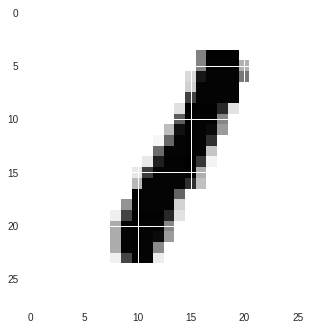

In [0]:

aaa=time.time()
for inputs, targets in pre_model.train_loader:
    print(f"This is the shape of one batch {inputs.shape}. What is the meaning of each dimension?  batch size * channels * height * width")
    print("target", targets.shape)
    img = inputs[0,0]
    
    plt.imshow(img)
    
    break
    
bbb = time.time()

print('Time to compute: ' , bbb-aaa)

#Creating a CNN

In [0]:
class Net(nn.Module):
    
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1, stride=1) # in 28, out 28, 
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) 
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, 3, padding=1) 
        self.conv6 = nn.Conv2d(128, 256, 3, padding=1)       
        
        
        self.fc1 = nn.Linear(256*7*7, 10)

    
    def forward(self, x):
       
      
        x = F.relu(self.conv1(x)) # in 28, out 28, 
        x = F.relu(self.conv2(x)) # 28x28        
        x = F.max_pool2d(x, 2)  # 14x14
             
        x = F.relu(self.conv3(x)) # 14x14      
        x = F.relu(self.conv4(x)) #  14x14 
        x = F.max_pool2d(x,2)
        x = F.relu(self.conv5(x)) # 14x14
        x = F.relu(self.conv6(x)) # 14x14
        
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
       
        return F.log_softmax(x, dim=1)

net = Net()

#Training

####Training

In [0]:
def train(model,train_loader, optimizer, epoch ):
    """Perform one epoch of training."""
    model.train()
    
    test_size = 0
    correct = 0
    train_loss = 0 
    
    for batch_idx, (inputs, target) in enumerate(train_loader):
        
        test_size += len(inputs)
        inputs, target = inputs.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, target)
        
        train_loss += loss_fn(output, target).item() 
        
        pred = output.max(1, keepdim=True)[1] 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        # Backprop
        loss.backward()
        optimizer.step()
        ###
    train_loss /= test_size
    train_acc = correct/test_size
        #if batch_idx % 1000 == 0:
         #   print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          #      epoch, batch_idx * len(inputs), len(train_loader) *len(inputs) ,
           #     100. * batch_idx / len(train_loader), loss.item()))
    return train_loss, train_acc

In [0]:
def test(model, test_loader):
    model.eval()
    
    valid_loss = 0
    correct = 0
    test_size = 0
    with torch.no_grad():
        for inputs, target in test_loader:
          
            inputs, target = inputs.to(device), target.to(device)
            
            
            output = model(inputs)
            test_size += len(inputs)
            valid_loss += test_loss_fn(output, target).item() 
            pred = output.max(1, keepdim=True)[1] 
            correct += pred.eq(target.view_as(pred)).sum().item()

    valid_loss /= test_size
    accuracy = correct / test_size
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        valid_loss, correct, test_size,
        100. * accuracy))
    
    return valid_loss, accuracy

In [0]:

model = Net().to(device)
test_accuracy = []
train_loss = []
train_accurary = []
valid_loss = []
tr_loss = []
nbr_epochs = 10

lr = 0.0025 # 

weight_decay = 0

# Surrogate loss used for training
loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')


optimizer = optim.SGD(model.parameters(), lr=lr)


print('Training beginning...')
start_time = time.time()
for epoch in range(1, nbr_epochs+1):
    print('Epoch ', epoch, ':')
    tr_loss, train_acc = train(model, pre_model.train_loader, optimizer, epoch)
    loss, acc = test(model, pre_model.valid_loader)
    
    # save results every epoch
    train_accurary.append(train_acc)
    train_loss.append(tr_loss)
    test_accuracy.append(acc)
    valid_loss.append(loss)

end_time = time.time()
print('Training on ' + str(nbr_epochs) + ' epochs done in ', str(end_time-start_time),' seconds')


Training beginning...
Epoch  1 :

Validation set: Average loss: 0.2176, Accuracy: 4663/5000 (93%)

Epoch  2 :

Validation set: Average loss: 0.1143, Accuracy: 4827/5000 (97%)

Epoch  3 :

Validation set: Average loss: 0.0607, Accuracy: 4905/5000 (98%)

Epoch  4 :

Validation set: Average loss: 0.0678, Accuracy: 4900/5000 (98%)

Epoch  5 :

Validation set: Average loss: 0.0539, Accuracy: 4916/5000 (98%)

Epoch  6 :

Validation set: Average loss: 0.0463, Accuracy: 4927/5000 (99%)

Epoch  7 :

Validation set: Average loss: 0.0496, Accuracy: 4924/5000 (98%)

Epoch  8 :

Validation set: Average loss: 0.0441, Accuracy: 4934/5000 (99%)

Epoch  9 :

Validation set: Average loss: 0.0470, Accuracy: 4937/5000 (99%)

Epoch  10 :

Validation set: Average loss: 0.0426, Accuracy: 4940/5000 (99%)

Training on 10 epochs done in  882.2229506969452  seconds


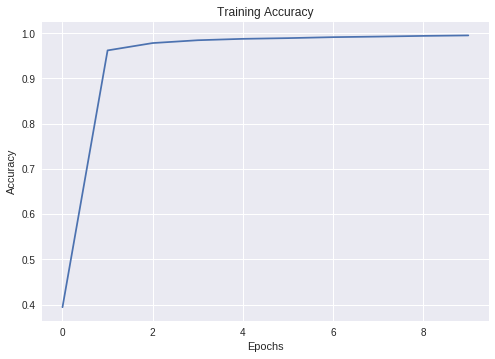

In [0]:
# Accuracy on train set
xvalues= np.arange(0,nbr_epochs,1)
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(xvalues, train_accurary)

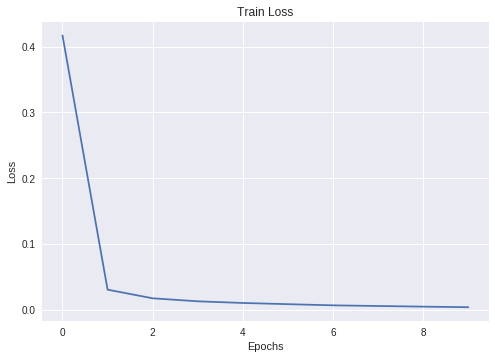

In [0]:
#error on training set
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(xvalues, train_loss)

With lr= 0.0025 , weight decay = 0 , Batch size of  4  and 


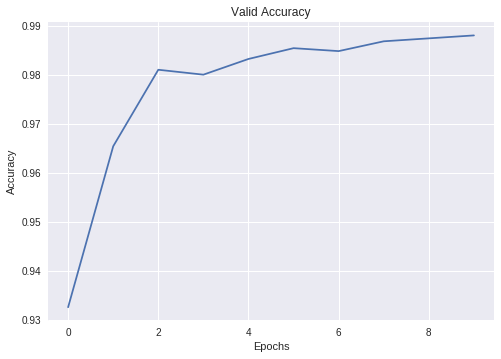

In [0]:
# Accuracy on validation set
plt.title('Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(xvalues, test_accuracy)

print('With lr=',lr,', weight decay = 0 ' ', Batch size of ', batchSize ,' and ')

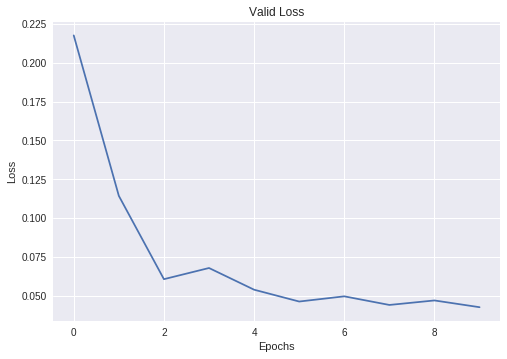

In [0]:
#error on validation set
plt.title('Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(xvalues, valid_loss)

#### Test Set Checking

In [0]:
loss, acc = test(model, pre_model.test_loader)
print('Loss on test set: ' , loss)
print('Accuracy on Test set: ' , acc)


Validation set: Average loss: 0.0400, Accuracy: 4944/5000 (99%)

Loss on test set:  0.040030140340328216
Accuracy on Test set:  0.9888
